In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"  --quietb


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quietb


In [5]:

!pip install "tf-models-official==2.13.*"  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 113.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 45.4 MB/s eta 0:00:00


In [6]:

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

In [7]:
!wget -O twitter.zip "https://tufts.box.com/shared/static/p66vbkli9wwd2rj4abtodtduhe4i8gbk.zip"



--2023-12-10 00:03:41--  https://tufts.box.com/shared/static/p66vbkli9wwd2rj4abtodtduhe4i8gbk.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/p66vbkli9wwd2rj4abtodtduhe4i8gbk.zip [following]
--2023-12-10 00:03:41--  https://tufts.box.com/public/static/p66vbkli9wwd2rj4abtodtduhe4i8gbk.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/p66vbkli9wwd2rj4abtodtduhe4i8gbk.zip [following]
--2023-12-10 00:03:41--  https://tufts.app.box.com/public/static/p66vbkli9wwd2rj4abtodtduhe4i8gbk.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [8]:
!unzip twitter.zip


Streaming output truncated to the last 5000 lines.
  inflating: twitter/train/class_1/62801.txt  
  inflating: twitter/train/class_1/62804.txt  
  inflating: twitter/train/class_1/62805.txt  
  inflating: twitter/train/class_1/62806.txt  
  inflating: twitter/train/class_1/62808.txt  
  inflating: twitter/train/class_1/62811.txt  
  inflating: twitter/train/class_1/62814.txt  
  inflating: twitter/train/class_1/62815.txt  
  inflating: twitter/train/class_1/62817.txt  
  inflating: twitter/train/class_1/6282.txt  
  inflating: twitter/train/class_1/62821.txt  
  inflating: twitter/train/class_1/62822.txt  
  inflating: twitter/train/class_1/62823.txt  
  inflating: twitter/train/class_1/62824.txt  
  inflating: twitter/train/class_1/62829.txt  
  inflating: twitter/train/class_1/6283.txt  
  inflating: twitter/train/class_1/62830.txt  
  inflating: twitter/train/class_1/62831.txt  
  inflating: twitter/train/class_1/62832.txt  
  inflating: twitter/train/class_1/62834.txt  
  inflating

In [9]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/twitter/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = train_ds.class_names
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/twitter/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/twitter/dev',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 68464 files belonging to 2 classes.
Using 54772 files for training.
Found 68464 files belonging to 2 classes.
Using 13692 files for validation.
Found 17117 files belonging to 2 classes.


## Loading models from TensorFlow Hub

In [10]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'jeongukjae/distilbert_en_cased_L-6_H-768_A-12/1'  #@param ["jeongukjae/distilbert_en_cased_L-6_H-768_A-12/1"]

map_name_to_handle = {
    'jeongukjae/distilbert_en_cased_L-6_H-768_A-12/1':
        "https://www.kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/en-cased-l-6-h-768-a-12/versions/1"

}
map_model_to_preprocess = {
    'jeongukjae/distilbert_en_cased_L-6_H-768_A-12/1':
        "https://kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/2"
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://www.kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/en-cased-l-6-h-768-a-12/versions/1
Preprocess model auto-selected: https://kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/2


In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

## Define model

In [12]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [13]:
classifier_model = build_classifier_model()


## Model training

In [14]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer



In [15]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [16]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [17]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://www.kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/en-cased-l-6-h-768-a-12/versions/1
Epoch 1/2
1712/1712 [==============================] - 973s 559ms/step - loss: 0.5478 - binary_accuracy: 0.6808 - val_loss: 0.4450 - val_binary_accuracy: 0.7664
Epoch 2/2
1712/1712 [==============================] - 1008s 589ms/step - loss: 0.3805 - binary_accuracy: 0.8123 - val_loss: 0.4328 - val_binary_accuracy: 0.7889


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [18]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

535/535 [==============================] - 115s 214ms/step - loss: 0.4449 - binary_accuracy: 0.7813
Loss: 0.4449131488800049
Accuracy: 0.7813284993171692


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


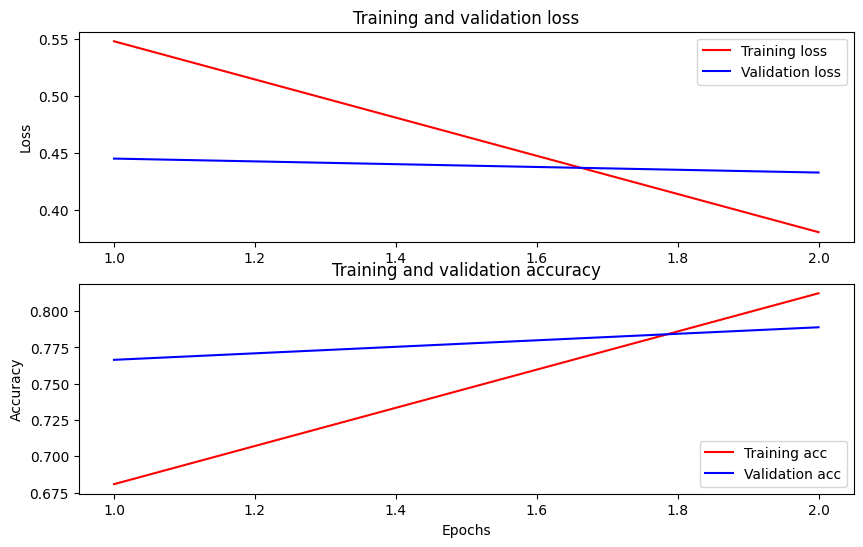

In [19]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Exporting the model

Now you just save your fine-tuned model for later use.

In [30]:
classifier_model.save('distilbert.keras')

In [31]:
new_model = tf.keras.models.load_model('distilbert.keras')

# Show the model architecture
new_model.summary()

TypeError: ignored

In [33]:
# Assuming you have a model named 'model'
classifier_model.save('distilbert.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
